In [304]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from src.helpers import *

import seaborn as sns; sns.set_theme()
import matplotlib.pylab as plt
import math
import pickle
import itertools
import random
import json
import statistics

from src.vcfs_parser import parser
from src.counts import count_snps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
based_on = [1, 2]

df = pd.read_csv('data/dataset.csv', index_col = 0, low_memory=False)
mut_cols = [col for col in df.columns.to_list() if col.isnumeric()]


lineages_of_interest = ['B.1.1.7','B.1.617.2','AY.12', 'AY.9', 'AY.4', 'B.1.1.318', 'AY.7']  # Lineages of interest
df = df.loc[df['lineage'].isin(lineages_of_interest)].copy()

lineages = df.loc[:,'lineage'].copy()
# cols.unique()
# cols[pd.isna(cols)] = 'unlabeled'

In [5]:
for bo in based_on:
    print('Based on {}'.format(bo))
    X = prepare_for_clustering(df, mut_cols, based_on = bo)

    X_transformed = TSNE(n_components=2,\
                      init='random', n_jobs=-1).fit_transform(X)
    X_transformed.shape

    # kmeans = KMeans(n_clusters=20, random_state=0).fit(X_transformed)
    # kmeans.labels_

    dbscan = DBSCAN(eps = 5, n_jobs = -1).fit(X_transformed)
    dbscan.labels_
    df['cluster_' + str(bo)] = dbscan.labels_
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    n_noise_ = list(dbscan.labels_).count(-1)
    print('Estimated number of clusters', n_clusters_)
    print('Estimated number of noise', n_noise_)


    colors = [str(k) for k in dbscan.labels_.tolist()]
    centroids = np.zeros((len(set(dbscan.labels_)), 2))
    for i, label in enumerate(np.unique(dbscan.labels_)):
        msk = dbscan.labels_ == label
        points = [X_transformed[j,:] for j, value in enumerate(msk) if value]
        centroids[i] = np.mean(points, axis=0)




    palette = sns.color_palette("Paired") + sns.color_palette("Set3", 12)
    g = sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1], hue = colors, style=lineages)
    g.scatter(x = centroids[:,0], y=centroids[:,1], color='black', marker='+', s=16, linewidths=0.7)
    g.set_title('TSNE->DBSCAN on the bin matrix ' + str(bo) + 's')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.savefig('TSNE->DBSCAN on the bin matrix ' + str(bo) + 's_final.pdf', format='pdf', bbox_inches='tight')
    plt.clf()

Based on 1
Samples length = 2787
Features length = 29903
Estimated number of clusters 33
Estimated number of noise 0
Based on 2
Samples length = 2787
Features length = 29903
Estimated number of clusters 9
Estimated number of noise 0


<Figure size 432x288 with 0 Axes>

In [6]:
%%time
counter = count_snps(df, lineages_of_interest, based_on)
counter.occurences_of_mutations()

Based on 1
Lineage B.1.1.7 is now being processed...
Lineage B.1.617.2 is now being processed...
Lineage AY.12 is now being processed...
Lineage AY.9 is now being processed...
Lineage AY.4 is now being processed...
Lineage B.1.1.318 is now being processed...
Lineage AY.7 is now being processed...
Based on 2
Lineage B.1.1.7 is now being processed...
Lineage B.1.617.2 is now being processed...
Lineage AY.12 is now being processed...
Lineage AY.9 is now being processed...
Lineage AY.4 is now being processed...
Lineage B.1.1.318 is now being processed...
Lineage AY.7 is now being processed...
CPU times: user 13min 25s, sys: 15.4 s, total: 13min 41s
Wall time: 13min 26s


### Calculate nodes dataframe old method(one lineage), new method(multiple lineages)

In [ ]:
# %%time
# # ------------- old method -------------
# lineage = 'B.1.1.7'
# nodes = counter.clusters_intersection()
# # nodes = nodes.loc[(nodes['cluster_1'] == 4) & (nodes['cluster_2'] == 0)].copy()
# nodes['samples'] = nodes.apply(lambda x: x['samples'][lineage] if lineage in x['samples'] else np.nan, axis = 1)
# nodes.dropna(how = 'any', inplace = True)

# for bo in based_on:
#     bo = str(bo)
#     pos_columns = ["{lineage}_C{cluster}_pos_{bo}".format(lineage = lineage, cluster = k, bo = bo) for k in nodes['cluster_' + bo].tolist()]
#     count_columns = ["{lineage}_C{cluster}_counts_{bo}".format(lineage = lineage, cluster = k, bo = bo) for k in nodes['cluster_' + bo].tolist()]
#     nodes['based_on_' + bo + '_pos'] = remove_nan_from_list_of_lists( \
#                                             counter.counts.loc[:, pos_columns].values.T.tolist())
#     nodes['based_on_' + bo + '_counts'] = remove_nan_from_list_of_lists( \
#                                             counter.counts.loc[:, count_columns].values.T.tolist())
#     nodes['snps_on_' + bo] =  nodes.apply(lambda x: [counter.get_snps_from_lineages_clusters_position(x['samples'], \
#                                                  region = 'NC_045512.2', \
#                                                  position = int(k)) for k in x['based_on_' + bo + '_pos']], axis = 1)
# nodes

# pickle.dump(nodes, open("data/nodes", "wb"))
# # nodes = pickle.load(open("data/nodes", "rb"))

In [410]:
# %%time
# # ------------- new method for all lineages -------------

# nodes = counter.clusters_intersection()

# # nodes.dropna(how = 'any', inplace = True)

# for bo in based_on:
#     bo = str(bo)
#     column_pos = []
#     column_counts = []
#     column_snps = []
#     for i in nodes.index:
#         d_pos = {}
#         d_counts = {}
#         d_snps = {}
#         for lineage in nodes.loc[i, 'samples'].keys():
#             pos_col = "{lineage}_C{cluster}_pos_{bo}".format(lineage = lineage, cluster = nodes.loc[i, 'cluster_' + bo], bo = bo)
#             count_col = "{lineage}_C{cluster}_counts_{bo}".format(lineage = lineage, cluster = nodes.loc[i, 'cluster_' + bo], bo = bo)

            
#             d_pos[lineage] = remove_nan_from_list( \
#                                     counter.counts.loc[:, pos_col].values.tolist())
#             d_counts[lineage] = remove_nan_from_list( \
#                                     counter.counts.loc[:, count_col].values.tolist())
#             d_snps[lineage] = [counter.get_snps_from_lineages_clusters_position( \
#                                         nodes.loc[i, 'samples'][lineage], \
#                                         region = 'NC_045512.2', \
#                                         position = int(k)) for k in d_pos[lineage]]
            
#         column_pos.append(d_pos)
#         column_counts.append(d_counts)
#         column_snps.append(d_snps)
#         print(i, ' done!')

#     nodes['based_on_' + bo + '_pos'] = column_pos
#     nodes['based_on_' + bo + '_counts'] = column_counts
#     nodes['snps_on_' + bo] = column_snps

# pickle.dump(nodes, open("data/nodes_all", "wb"))
nodes = pickle.load(open("data/nodes_all", "rb"))

In [272]:
for i in nodes.index:
    counts = {}
    samples_dict = nodes.loc[i, 'samples']
    for key, value in samples_dict.items():
        increase_value_of_dict_by_value_new(counts, key, len(value))
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    (labels, sizes) = zip(*counts.items())
    #     labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
    #     sizes = [15, 30, 45, 10]
    #     explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.axis('tight')
    ax1.axis('off')
#     fig1.set_size_inches(10, 10)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90, labeldistance = None, rotatelabels = True,
               wedgeprops={"edgecolor":"0",'linewidth': 0})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.savefig('data/circular_images/{}.png'.format(i), transparent=True, bbox_inches='tight', pad_inches = 0)
    plt.clf()
    plt.close()
#     break

### Calculate fully connected graph edges old method(one lineage), new method(multiple lineages)

In [187]:
# # ------------- old ---------------
# threshold = 1
# edges = []
# j_loop_indecies = nodes.index.tolist()
# # test = []
# for i in nodes.index:
#     j_loop_indecies.remove(i)

#     pos_i_dict = list_to_index_val_dict(nodes.loc[i, 'based_on_1_pos'] + nodes.loc[i, 'based_on_2_pos'])
#     counts_i = nodes.loc[i, 'based_on_1_counts'] + nodes.loc[i, 'based_on_2_counts']
# #     print(pos_i_dict)
#     for j in j_loop_indecies:
#         pos_j_dict = list_to_index_val_dict(nodes.loc[j, 'based_on_1_pos'] + nodes.loc[j, 'based_on_2_pos'])
#         counts_j = nodes.loc[j, 'based_on_1_counts'] + nodes.loc[j, 'based_on_2_counts']
# #         print(pos_j_dict)
#         d = {}
#         intersection = list(set(pos_i_dict) & set(pos_j_dict))
#         for inter in intersection:
# #             test.append((pos_i_dict[inter], pos_j_dict[inter]))
# #             d[inter] = ((pos_i_dict[inter], get_list_items_from_idx_list(counts_i, pos_i_dict[inter])), 
# #                         (pos_j_dict[inter], get_list_items_from_idx_list(counts_j, pos_j_dict[inter])))
#             d[str(int(inter))] = min(get_list_items_from_idx_list(counts_i, pos_i_dict[inter]) + 
#                            get_list_items_from_idx_list(counts_j, pos_j_dict[inter]))
        
#         keys_to_be_deleted = []
#         for key, value in d.items():
#             if value < threshold:
#                 keys_to_be_deleted.append(key)
#         for key in keys_to_be_deleted:
#             d.pop(key)
#         if not d:
#             print('Empty')
#         title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['weights']) \
#                             .reset_index() \
#                             .rename(columns = {'index':'position'}) \
#                             .to_html(index = False)
#         edges.append((i, j, {'weights' : d,
#                              'weight' : len(d),
#                              'value' : len(d),
#                              'title' : title}))
# #         print(d)
# #         break
# #     break

In [395]:
# ------------- new ---------------
threshold = 1
edges = []
j_loop_indecies = nodes.index.tolist()
# test = []
for i in nodes.index:
    j_loop_indecies.remove(i)

    keys_i = nodes.loc[i, 'samples'].keys()
    
    for key_i in keys_i:
        pos_i_dict = list_to_index_val_dict(nodes.loc[i, 'based_on_1_pos'][key_i] + nodes.loc[i, 'based_on_2_pos'][key_i])
        counts_i = nodes.loc[i, 'based_on_1_counts'][key_i] + nodes.loc[i, 'based_on_2_counts'][key_i]
    #     print(pos_i_dict)
        for j in j_loop_indecies:
            for key_j in nodes.loc[j, 'samples']:
                pos_j_dict = list_to_index_val_dict(nodes.loc[j, 'based_on_1_pos'][key_j] + nodes.loc[j, 'based_on_2_pos'][key_j])
                counts_j = nodes.loc[j, 'based_on_1_counts'][key_j] + nodes.loc[j, 'based_on_2_counts'][key_j]
        #         print(pos_j_dict)
                d = {}
                intersection = list(set(pos_i_dict) & set(pos_j_dict))
                for inter in intersection:
                    d[str(int(inter))] = min(get_list_items_from_idx_list(counts_i, pos_i_dict[inter]) + 
                                             get_list_items_from_idx_list(counts_j, pos_j_dict[inter]))

                keys_to_be_deleted = []
                for key, value in d.items():
                    if value < threshold:
                        keys_to_be_deleted.append(key)
                for key in keys_to_be_deleted:
                    d.pop(key)
                if d:
                    (pos, min_weight) = zip(*d.items())
                    length = len(pos)
                    _from = [key_i] * length
                    _to = [key_j] * length

                    if len(pos) == len(min_weight) == len(_from) == len(_to):
                        title = pd.DataFrame.from_records(zip(_from, _to, pos, min_weight), columns = ['from', 'to', 'position', 'weights']).to_html(index = False)
                        edges.append((i, j, {'weights' : d,
                                             'value' : len(d),
                                             'title' : title}))
                    else:
                        print('Something went wrong with the lengths')
        #         print(d)
        #         break
        #     break

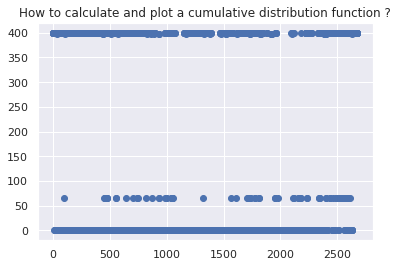

In [173]:
from scipy.stats import norm
Q = 400
cols = {
    'from' : [],
    'to' : [],
    'weight' : []
}
for edge in edges:
    cols['from'].append(edge[0])
    cols['to'].append(edge[1])
    cols['weight'].append(edge[2]['value'])
    
x = cols['weight']
_std = statistics.pstdev(cols['weight'])
_mean = statistics.mean(cols['weight'])
_min = min(cols['weight'])
_max = max(cols['weight'])
# cols['weight'] = [((w - _min) / (_max - _min)) * Q  for w in cols['weight']]
cols['weight'] = [(w - _mean) / _std for w in cols['weight']]
cols['weight'] = norm.cdf(cols['weight'], loc=0, scale=0.04) * Q
pd.DataFrame.from_dict(cols).to_csv('data/fully-connected-graph.csv', header = False, index = False, sep = " ")
x = cols['weight']
plt.scatter(range(len(x)), x)

plt.title('How to calculate and plot a cumulative distribution function ?')

plt.show()

In [174]:
!mcl data/fully-connected-graph.csv --abc -I 30 -scheme 7 -o data/fully-connected-graph-clusters.out
# !mcxload -abc data/fully-connected-graph.csv --stream-mirror -write-tab data.tab -o data/fully-connected-graph.mci
# !mcxi /data/fully-connected-graph.mci lm tp -1 mul add /data/check wm
# !mcxdump -imx data/data/check -tab data.tab --dump-table

[mcl] new tab created
[mcl] pid 16259
 ite ---------------  chaos  time hom(avg,lo,hi) m-ie m-ex i-ex fmv
  1  ...............   2.52  0.00 1.16/0.73/2.93 0.98 0.72 0.72 100
  2  ...............   4.71  0.00 0.74/0.34/1.23 0.53 0.45 0.32 100
  3  ...............   2.48  0.00 0.91/0.52/1.22 0.57 0.28 0.09 100
  4  ...............   0.09  0.00 1.00/0.91/1.00 0.31 0.19 0.02  36
  5  ...............   0.00  0.00 1.00/1.00/1.00 0.99 0.91 0.02   0
[mcl] jury pruning marks: <99,99,99>, out of 100
[mcl] jury pruning synopsis: <99.0 or perfect> (cf -scheme, -do log)
[mcl] output is in data/fully-connected-graph-clusters.out
[mcl] 9 clusters found
[mcl] output is in data/fully-connected-graph-clusters.out

Please cite:
    Stijn van Dongen, Graph Clustering by Flow Simulation.  PhD thesis,
    University of Utrecht, May 2000.
       (  http://www.library.uu.nl/digiarchief/dip/diss/1895620/full.pdf
       or  http://micans.org/mcl/lit/svdthesis.pdf.gz)
OR
    Stijn van Dongen, A cluster algorithm

### Calculate arrow edges old method(one lineage), new method(multiple lineages)

In [202]:
# -----------------old-----------------
# edges = []

# for bo in based_on:
#     fo = str(based_on[~based_on.index(bo)])
#     bo = str(bo)
#     for i in nodes.index:


#         pos_i = nodes.loc[i, 'based_on_' + bo + '_pos']

#         same_clusters = nodes.loc[(nodes['cluster_' + bo] == nodes.loc[i, 'cluster_' + bo]) & \
#                                   (nodes['cluster_' + fo] != nodes.loc[i, 'cluster_' + fo]), :]

#         if not same_clusters.empty:
#     #             print(same_clusters[['cluster_1', 'cluster_2']])
#             for j in same_clusters.index:
#                 d = {}
#                 for l, snp_i in enumerate(nodes.loc[i, 'snps_on_'+ bo]):
#                     if snp_i[0] == 0:
#                         pos_j = same_clusters.loc[j, 'based_on_' + bo + '_pos']

#                         for k, snp_j in enumerate(same_clusters.loc[j, 'snps_on_'+ bo]):
#                             if (snp_j[0] > 0) and (pos_j[k] == pos_i[l]):
#     #                                 print('on {bo} empty pos {pos_i} of clust {i} -> {pos_j} of clust {j}'.format(bo = bo, pos_i = pos_i[l], pos_j = pos_j[k], i = i, j = j))
#                                 d[pos_i[l]] = (snp_i, snp_j)
#             if d:
#                 title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['from', 'to']) \
#                             .reset_index() \
#                             .rename(columns = {'index':'position'}) \
#                             .to_html(index = False)
#                 edges.append((i, j, {'color' : 'blue' if bo == "1" else 'red',
#                                      'arrows' : 'to',
#                                      'data' : d, 
#                                      'title' : title}))

In [420]:
# -----------------new-----------------
edges = []
for bo in based_on:
    fo = str(based_on[~based_on.index(bo)])
    bo = str(bo)
    for i in nodes.index:


        pos_i = flatten_list_of_lists(list(nodes.loc[i, 'based_on_' + bo + '_pos'].values()))

        same_clusters = nodes.loc[(nodes['cluster_' + bo] == nodes.loc[i, 'cluster_' + bo]) & \
                                  (nodes['cluster_' + fo] != nodes.loc[i, 'cluster_' + fo]), :]

        if not same_clusters.empty:
    #             print(same_clusters[['cluster_1', 'cluster_2']])
            for j in same_clusters.index:
                d = {}
                i_snps = flatten_list_of_lists(list(nodes.loc[i, 'snps_on_'+ bo].values()))
                for l, snp_i in enumerate(i_snps):
                    if snp_i[0] == 0:
                        pos_j = flatten_list_of_lists(list(same_clusters.loc[j, 'based_on_' + bo + '_pos'].values()))
                        j_snps = flatten_list_of_lists(list(same_clusters.loc[j, 'snps_on_'+ bo].values()))
                        
                        for k, snp_j in enumerate(j_snps):
                            if (snp_j[0] > 0) and (pos_j[k] == pos_i[l]):
    #                                 print('on {bo} empty pos {pos_i} of clust {i} -> {pos_j} of clust {j}'.format(bo = bo, pos_i = pos_i[l], pos_j = pos_j[k], i = i, j = j))
                                d[pos_i[l]] = (snp_i, snp_j)
            if d:
                title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['from', 'to']) \
                            .reset_index() \
                            .rename(columns = {'index':'position'}) \
                            .to_html(index = False)
                edges.append((i, j, {'color' : 'blue' if bo == "1" else 'red',
                                     'arrows' : 'to',
                                     'data' : d, 
                                     'title' : title
                                    }))

### Initiate graph old method(one lineage), new method(multiple lineages)

In [ ]:
#-------------------old--------------
# G = nx.DiGraph(name = lineage)
# G.add_nodes_from(list(nodes.to_dict(orient='index').items()))


# G.add_edges_from(edges)


# net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True, directed = True, heading = G.name)

# net.from_nx(G)
# for i in range(len(net.nodes)):
#     pos = []
#     snps = []
#     index = []
#     total = []
#     f = []
# #     total_len = 0
#     for bo in based_on:
#         bo = str(bo)
        
#         pos = extend_list(pos, [int(k) for k in net.nodes[i]['based_on_{}_pos'.format(bo)]])
#         f = extend_list(f, ["{:.2f}".format(k) for k in net.nodes[i]['based_on_{}_counts'.format(bo)]])
#         length = len(pos)
#         index = extend_list(index, [bo] * length)
        
#         total = extend_list(total, [k[0] for k in net.nodes[i]['snps_on_{}'.format(bo)]])
#         snps = extend_list(snps, [str(k[1]) for k in net.nodes[i]['snps_on_{}'.format(bo)]])
    
#     print(len(pos))
#     print(len(index))
#     net.nodes[i]['title'] = pd.DataFrame.from_records(zip(index, pos, f, total, snps), columns = ['Based_on','Position', 'f', 'Total', 'Snps']).to_html(index = False) 
# #         total_len = total_len + length 
# #     net.nodes[i]['label'] = total_len

# # net.show('example3.html')

In [ ]:
#-------------------new--------------
d = pd.read_csv('data/fully-connected-graph-clusters.out', sep='\t', header = None).T.to_dict(orient='list')
d = remove_nan_from_dict_of_lists(d)
d = int_dict_of_lists(d)
groups = {}
for key, value in d.items():
    for element in value:
        groups[element] = key

nodes['id'] = nodes.index
        
G = nx.DiGraph(name = lineages_of_interest)
G.add_nodes_from(list(nodes.to_dict(orient='index').items()))


G.add_edges_from(edges)

net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True, directed = True, heading = " ".join(str(x) for x in G.name))
net.set_options(json.dumps({
    "configure": {
        "enabled": False
    },
    "nodes":{
        "borderWidth": 10,
        "borderWidthSelected": 10,
        "size": 400,
        "chosen": True,
        "font": {
            "size": 11,
        }
    },
    "edges": {
        "scaling": {
            "min": 0.1,
            "max": 1,
        },
        "selectionWidth" : 0,
        "color": {
            "inherit": False
        },
        "smooth": {
            "enabled": False,
            "type": "continuous"
        }
    },
    "interaction": {
        "dragNodes": True,
        "hideEdgesOnDrag": False,
        "hideNodesOnDrag": False
    },
    "physics": {
        "enabled": False,
    },
    "layout": {
        "randomSeed": 100,
    }
}))

net.from_nx(G)
for i in range(len(net.nodes)):
    pos = []
    snps = []
    index = []
    total = []
    lineage = []
    f = []
#     total_len = 0
    for bo in based_on:
        for lin in net.nodes[i]['based_on_{}_pos'.format(bo)].keys():
            bo = str(bo)

            pos = extend_list(pos, [int(k) for k in net.nodes[i]['based_on_{}_pos'.format(bo)][lin]])
            f = extend_list(f, ["{:.2f}".format(k) for k in net.nodes[i]['based_on_{}_counts'.format(bo)][lin]])
            
            length = len(net.nodes[i]['based_on_{}_pos'.format(bo)][lin])
            index = extend_list(index, [bo] * length)
            lineage = extend_list(lineage, [lin] * length)


            total = extend_list(total, [k[0] for k in net.nodes[i]['snps_on_{}'.format(bo)][lin]])
            snps = extend_list(snps, [str(k[1]) for k in net.nodes[i]['snps_on_{}'.format(bo)][lin]])
            
    if len(index) == len(lineage) == len(pos) == len(f) == len(total) == len(snps):
        net.nodes[i]['title'] = pd.DataFrame.from_records(zip(index, lineage, pos, f, total, snps), columns = ['Based_on', 'Lineage', 'Position', 'f', 'Total', 'Snps']).to_html(index = False) 
    #     total_len = total_len + length 
        net.nodes[i]['label'] = " ".join(str(x) for x in list(set(lineage))) + '\n' + str(net.nodes[i]['id'])
        net.nodes[i]['group'] = groups[net.nodes[i]['id']]
        net.nodes[i]['shape'] = "circularImage"
        net.nodes[i]['image'] = "data/circular_images/{}.png".format(net.nodes[i]['id'])
#         net.nodes[i]['color'] = 'black'
    else:
        print('Something went wrong with the lengths')

net.show('example6.html')